In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import keras
import warnings

from sklearn.preprocessing import StandardScaler,OneHotEncoder,label_binarize, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from hpelm import ELM
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, auc, accuracy_score
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Group_14_data_cleaned.csv", index_col=0)
data.head()

,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
Auction_ID,,,,,,,,,,,
732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,0.444444,0
732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,0.444444,0
732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,0.444444,0
732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,0.444444,0
900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,0.666667,0


In [3]:
data['Class'].value_counts()

0    5646
1     675
Name: Class, dtype: int64

In [4]:
# Split the data into training and testing sets
X = data.drop(['Class', 'Bidder_ID'], axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ELM

In [31]:
class ELMClassifier:
    def __init__(self, n_hidden=512, activation="tanh", n_classes=2):
        self.n_hidden = n_hidden
        self.activation = activation
        self.n_classes = n_classes
        self.elm = ELM(inputs=X_train.shape[1], outputs=2, classification="c")
        self.elm.add_neurons(n_hidden, activation)

    def fit(self, X, y):
        y_bin = label_binarize(y, classes=range(self.n_classes))
        self.elm.train(X, y_bin)

    def predict(self, X):
        y_pred = self.elm.predict(X)
        return np.argmax(y_pred, axis=1)

    def predict_proba(self, X):
        y_pred = self.elm.predict(X)
        return y_pred

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True):
        return {'n_hidden': self.n_hidden, 'activation': self.activation, 'batch': self.batch, 'n_classes': self.n_classes}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.values
y_test = y_test.values

# One-hot encode the target variable
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(y_test.reshape(-1, 1)).toarray()

# Train and evaluate the ELM model on the scaled data
elm_classifier = ELMClassifier()
elm_classifier.fit(X_train_scaled, y_train_encoded)
score = elm_classifier.score(X_test_scaled, y_test)
print("Accuracy:", score)


# Get the predicted labels and convert them back from one-hot encoding
y_pred_encoded = elm_classifier.predict_proba(X_test_scaled)
y_pred = np.argmax(y_pred_encoded, axis=1)

# Get the true labels and convert them back from one-hot encoding
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
print(classification_report(y_test, y_pred))



Accuracy: 0.9873517786561264
[[1122   11]
 [   5  127]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1133
           1       0.92      0.96      0.94       132

    accuracy                           0.99      1265
   macro avg       0.96      0.98      0.97      1265
weighted avg       0.99      0.99      0.99      1265



Neurons: 16 Accuracy: 0.9557312252964427
Neurons: 32 Accuracy: 0.9675889328063241
Neurons: 64 Accuracy: 0.9731225296442688
Neurons: 128 Accuracy: 0.9778656126482214
Neurons: 256 Accuracy: 0.9818181818181818
Neurons: 512 Accuracy: 0.9873517786561264
Neurons: 1024 Accuracy: 0.9857707509881423
{'best_score': 0.9873517786561264, 'best_neurons': 512}


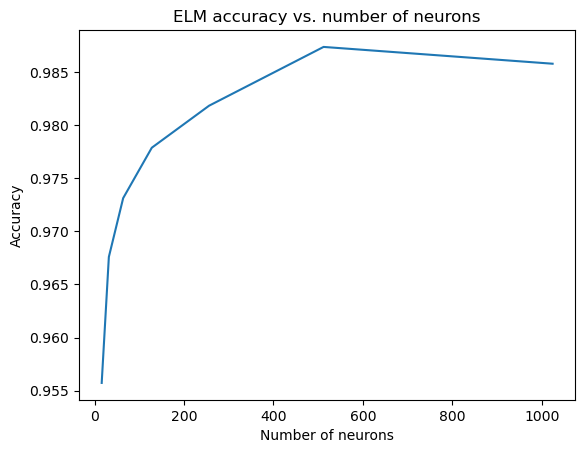

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.values
y_test = y_test.values


# One-hot encode the target variable
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(y_test.reshape(-1, 1)).toarray()


n_neurons = [16, 32, 64, 128, 256, 512, 1024]
scores = []

for neurons in n_neurons:
    # Train and evaluate the ELM model on the scaled data
    elm_classifier = ELMClassifier(n_hidden=neurons)
    elm_classifier.fit(X_train_scaled, y_train_encoded)
    score = elm_classifier.score(X_test_scaled, y_test)
    print("Neurons:", neurons, "Accuracy:", score)
    scores.append(score)

best_score = max(scores)
best_neurons = n_neurons[scores.index(best_score)]
result = {'best_score': best_score, 'best_neurons': best_neurons}
print(result)

# Plot the scores with the number of neurons
plt.plot(n_neurons, scores)
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.title('ELM accuracy vs. number of neurons')
plt.show()


We can see that ELM performs the best for number of neurons: 512 and the score reduces by increasing the number of neurons further. 

# Training with best parameters

In [41]:
# Train and evaluate the ELM model on the scaled data
elm_classifier = ELMClassifier(n_hidden=512)
elm_classifier.fit(X_train_scaled, y_train_encoded)
score = elm_classifier.score(X_test_scaled, y_test)
print("Accuracy:", score)


# Get the predicted labels and convert them back from one-hot encoding
y_pred_encoded = elm_classifier.predict_proba(X_test_scaled)
y_pred = np.argmax(y_pred_encoded, axis=1)

# Get the true labels and convert them back from one-hot encoding
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
print(classification_report(y_test, y_pred))

Accuracy: 0.9865612648221344
[[1120   13]
 [   4  128]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1133
           1       0.91      0.97      0.94       132

    accuracy                           0.99      1265
   macro avg       0.95      0.98      0.97      1265
weighted avg       0.99      0.99      0.99      1265



## SVM with Linear Kernel 

In [46]:
from sklearn.metrics import make_scorer, roc_auc_score

# Define AUC as a scoring metric
auc_scorer = make_scorer(roc_auc_score)

# RANDOM SEARCH FOR 20 COMBINATIONS OF PARAMETERS
rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 5),
             'kernel': ['linear']}

rand_search = RandomizedSearchCV(SVC(), 
                                 param_distributions=rand_list, 
                                 n_iter=50, 
                                 n_jobs=4, 
                                 cv=3, 
                                 random_state=2017, 
                                 scoring=auc_scorer) 
rand_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters: ", rand_search.best_params_)
print("AUC score: ", rand_search.best_score_)


Best hyperparameters:  {'C': 2.209602254061174, 'gamma': 3.935350823412439, 'kernel': 'linear'}
AUC score:  0.9849473524897286


In [47]:
# Use the best hyperparameters to create a new SVM model
best_svm_model = SVC(C=rand_search.best_params_['C'], kernel=rand_search.best_params_['kernel'], gamma=rand_search.best_params_['gamma'])

# Train the new SVM model using the training data
best_svm_model.fit(X_train, y_train)

# Use the trained classifier to predict the class labels for the test data
y_pred = best_svm_model.predict(X_test)


# Evaluate the classifier's performance on the test data
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1103   30]
 [   2  130]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1133
           1       0.81      0.98      0.89       132

    accuracy                           0.97      1265
   macro avg       0.91      0.98      0.94      1265
weighted avg       0.98      0.97      0.98      1265



## SVM with non linear kernel

In [49]:
from sklearn.svm import SVC
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

# Define the model
svm_model = SVC()

# Define the hyperparameters to search over
rand_list = {"C": stats.uniform(2, 100),
             "gamma": stats.uniform(0.1, 10),
             'kernel': ['rbf', 'poly']}

# Perform the randomized search
rand_search = RandomizedSearchCV(svm_model, param_distributions=rand_list, n_iter=50, n_jobs=-1, cv=3, random_state=42, scoring='accuracy')
rand_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters: ", rand_search.best_params_)
print("Accuracy score: ", rand_search.best_score_)



Best hyperparameters:  {'C': 18.52669390630025, 'gamma': 0.2563640674119393, 'kernel': 'rbf'}
Accuracy score:  0.9932756288184654


In [51]:
# Use the best hyperparameters to create a new SVM model
best_svm_model = SVC(C=rand_search.best_params_['C'], kernel=rand_search.best_params_['kernel'], gamma=rand_search.best_params_['gamma'])

# Train the new SVM model using the training data
best_svm_model.fit(X_train, y_train)

# Use the trained classifier to predict the class labels for the test data
y_pred = best_svm_model.predict(X_test)

# Evaluate the classifier's performance on the test data
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1115   18]
 [   7  125]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1133
           1       0.87      0.95      0.91       132

    accuracy                           0.98      1265
   macro avg       0.93      0.97      0.95      1265
weighted avg       0.98      0.98      0.98      1265



## Training a Neural Network

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint


# Define the neural network model
def create_model(num_layers=1, num_neurons=10):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
    for i in range(num_layers):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create a KerasClassifier with fixed batch_size and epochs
model = KerasClassifier(build_fn=create_model, epochs=10, verbose=2)

# Define the hyperparameter distribution to search
param_dist = {
    'num_layers': [1,2,3],
    'num_neurons': [8,32,64,128, 256],
}

# Perform randomized search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=10)
random_search_result = random_search.fit(X_train, y_train)

# Print the results
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


Epoch 1/10
106/106 - 1s - loss: 0.4619 - accuracy: 0.8935 - 703ms/epoch - 7ms/step
Epoch 2/10
106/106 - 0s - loss: 0.3196 - accuracy: 0.8935 - 139ms/epoch - 1ms/step
Epoch 3/10
106/106 - 0s - loss: 0.2562 - accuracy: 0.8935 - 139ms/epoch - 1ms/step
Epoch 4/10
106/106 - 0s - loss: 0.2094 - accuracy: 0.8935 - 135ms/epoch - 1ms/step
Epoch 5/10
106/106 - 0s - loss: 0.1744 - accuracy: 0.8935 - 152ms/epoch - 1ms/step
Epoch 6/10
106/106 - 0s - loss: 0.1423 - accuracy: 0.8967 - 140ms/epoch - 1ms/step
Epoch 7/10
106/106 - 0s - loss: 0.1106 - accuracy: 0.9593 - 136ms/epoch - 1ms/step
Epoch 8/10
106/106 - 0s - loss: 0.0810 - accuracy: 0.9739 - 139ms/epoch - 1ms/step
Epoch 9/10
106/106 - 0s - loss: 0.0622 - accuracy: 0.9789 - 150ms/epoch - 1ms/step
Epoch 10/10
106/106 - 0s - loss: 0.0534 - accuracy: 0.9801 - 173ms/epoch - 2ms/step
53/53 - 0s - loss: 0.0560 - accuracy: 0.9769 - 275ms/epoch - 5ms/step
Epoch 1/10
106/106 - 1s - loss: 0.5474 - accuracy: 0.8600 - 839ms/epoch - 8ms/step
Epoch 2/10
106/1

106/106 - 0s - loss: 0.0632 - accuracy: 0.9754 - 141ms/epoch - 1ms/step
Epoch 3/10
106/106 - 0s - loss: 0.0465 - accuracy: 0.9804 - 141ms/epoch - 1ms/step
Epoch 4/10
106/106 - 0s - loss: 0.0429 - accuracy: 0.9819 - 143ms/epoch - 1ms/step
Epoch 5/10
106/106 - 0s - loss: 0.0407 - accuracy: 0.9813 - 142ms/epoch - 1ms/step
Epoch 6/10
106/106 - 0s - loss: 0.0395 - accuracy: 0.9819 - 142ms/epoch - 1ms/step
Epoch 7/10
106/106 - 0s - loss: 0.0372 - accuracy: 0.9840 - 142ms/epoch - 1ms/step
Epoch 8/10
106/106 - 0s - loss: 0.0377 - accuracy: 0.9849 - 142ms/epoch - 1ms/step
Epoch 9/10
106/106 - 0s - loss: 0.0368 - accuracy: 0.9849 - 143ms/epoch - 1ms/step
Epoch 10/10
106/106 - 0s - loss: 0.0399 - accuracy: 0.9825 - 142ms/epoch - 1ms/step
53/53 - 0s - loss: 0.0500 - accuracy: 0.9751 - 185ms/epoch - 3ms/step
Epoch 1/10
106/106 - 1s - loss: 0.3243 - accuracy: 0.8822 - 609ms/epoch - 6ms/step
Epoch 2/10
106/106 - 0s - loss: 0.0714 - accuracy: 0.9683 - 144ms/epoch - 1ms/step
Epoch 3/10
106/106 - 0s - l

Epoch 4/10
106/106 - 0s - loss: 0.0529 - accuracy: 0.9757 - 193ms/epoch - 2ms/step
Epoch 5/10
106/106 - 0s - loss: 0.0479 - accuracy: 0.9777 - 175ms/epoch - 2ms/step
Epoch 6/10
106/106 - 0s - loss: 0.0461 - accuracy: 0.9798 - 132ms/epoch - 1ms/step
Epoch 7/10
106/106 - 0s - loss: 0.0419 - accuracy: 0.9825 - 149ms/epoch - 1ms/step
Epoch 8/10
106/106 - 0s - loss: 0.0407 - accuracy: 0.9837 - 150ms/epoch - 1ms/step
Epoch 9/10
106/106 - 0s - loss: 0.0406 - accuracy: 0.9819 - 142ms/epoch - 1ms/step
Epoch 10/10
106/106 - 0s - loss: 0.0388 - accuracy: 0.9825 - 155ms/epoch - 1ms/step
53/53 - 0s - loss: 0.0496 - accuracy: 0.9769 - 192ms/epoch - 4ms/step
Epoch 1/10
106/106 - 1s - loss: 0.5528 - accuracy: 0.7754 - 701ms/epoch - 7ms/step
Epoch 2/10
106/106 - 0s - loss: 0.2135 - accuracy: 0.9018 - 268ms/epoch - 3ms/step
Epoch 3/10
106/106 - 0s - loss: 0.0974 - accuracy: 0.9647 - 181ms/epoch - 2ms/step
Epoch 4/10
106/106 - 0s - loss: 0.0607 - accuracy: 0.9754 - 229ms/epoch - 2ms/step
Epoch 5/10
106/1

106/106 - 0s - loss: 0.0357 - accuracy: 0.9864 - 171ms/epoch - 2ms/step
Epoch 6/10
106/106 - 0s - loss: 0.0355 - accuracy: 0.9843 - 179ms/epoch - 2ms/step
Epoch 7/10
106/106 - 0s - loss: 0.0327 - accuracy: 0.9884 - 186ms/epoch - 2ms/step
Epoch 8/10
106/106 - 0s - loss: 0.0280 - accuracy: 0.9884 - 172ms/epoch - 2ms/step
Epoch 9/10
106/106 - 0s - loss: 0.0257 - accuracy: 0.9911 - 168ms/epoch - 2ms/step
Epoch 10/10
106/106 - 0s - loss: 0.0219 - accuracy: 0.9920 - 169ms/epoch - 2ms/step
53/53 - 0s - loss: 0.0300 - accuracy: 0.9899 - 193ms/epoch - 4ms/step
Epoch 1/10
106/106 - 1s - loss: 0.1559 - accuracy: 0.9487 - 692ms/epoch - 7ms/step
Epoch 2/10
106/106 - 0s - loss: 0.0497 - accuracy: 0.9763 - 214ms/epoch - 2ms/step
Epoch 3/10
106/106 - 0s - loss: 0.0458 - accuracy: 0.9798 - 233ms/epoch - 2ms/step
Epoch 4/10
106/106 - 0s - loss: 0.0420 - accuracy: 0.9834 - 218ms/epoch - 2ms/step
Epoch 5/10
106/106 - 0s - loss: 0.0417 - accuracy: 0.9804 - 218ms/epoch - 2ms/step
Epoch 6/10
106/106 - 0s - l

In [58]:
# Best: 0.990506 using {'num_neurons': 128, 'num_layers': 2}

## Training the best architecture

In [55]:

best_num_layers = random_search_result.best_params_["num_layers"]
best_num_neurons = random_search_result.best_params_["num_neurons"]
model = create_model(num_layers=best_num_layers, num_neurons=best_num_neurons)
model.fit(X_train, y_train, epochs=50, verbose=2)


Epoch 1/50
158/158 - 1s - loss: 0.1460 - accuracy: 0.9502 - 668ms/epoch - 4ms/step
Epoch 2/50
158/158 - 0s - loss: 0.0458 - accuracy: 0.9808 - 271ms/epoch - 2ms/step
Epoch 3/50
158/158 - 0s - loss: 0.0431 - accuracy: 0.9820 - 314ms/epoch - 2ms/step
Epoch 4/50
158/158 - 0s - loss: 0.0401 - accuracy: 0.9828 - 239ms/epoch - 2ms/step
Epoch 5/50
158/158 - 0s - loss: 0.0372 - accuracy: 0.9838 - 234ms/epoch - 1ms/step
Epoch 6/50
158/158 - 0s - loss: 0.0366 - accuracy: 0.9850 - 240ms/epoch - 2ms/step
Epoch 7/50
158/158 - 0s - loss: 0.0325 - accuracy: 0.9858 - 288ms/epoch - 2ms/step
Epoch 8/50
158/158 - 0s - loss: 0.0285 - accuracy: 0.9881 - 244ms/epoch - 2ms/step
Epoch 9/50
158/158 - 0s - loss: 0.0247 - accuracy: 0.9917 - 246ms/epoch - 2ms/step
Epoch 10/50
158/158 - 0s - loss: 0.0191 - accuracy: 0.9941 - 243ms/epoch - 2ms/step
Epoch 11/50
158/158 - 0s - loss: 0.0161 - accuracy: 0.9955 - 236ms/epoch - 1ms/step
Epoch 12/50
158/158 - 0s - loss: 0.0181 - accuracy: 0.9945 - 238ms/epoch - 2ms/step
E

In [56]:

# Use the trained classifier to predict the class labels for the test data
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
# Evaluate the classifier's performance on the test data
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

40/40 [==============================] - 0s 1ms/step
[[1129    4]
 [   1  131]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1133
           1       0.97      0.99      0.98       132

    accuracy                           1.00      1265
   macro avg       0.98      0.99      0.99      1265
weighted avg       1.00      1.00      1.00      1265



In [57]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)


# Print the accuracy without rounding
print("Accuracy: {:.4f}".format(accuracy))

40/40 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 0.9960
Accuracy: 0.9960


Both SVM and Neural Network performs with a similar accuaracy. Neural network performs slightly better than non-linear SVM. 

# Variable Selection

In [ ]:
# Split the data into training and testing sets
X = data[['Bidder_Tendency', 'Successive_Outbidding', 'Last_Bidding',
       'Winning_Ratio']]
y = data['Class']
X_train_sl_ft_1, X_test_sl_ft_1, y_train_sl_ft_1, y_test_sl_ft_1 = train_test_split(X, y, test_size=0.2)

In [ ]:
# Define the neural network model
def create_model_(num_layers=1, num_neurons=10):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train_.shape[1], activation='relu'))
    for i in range(num_layers):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = create_model_(num_layers=2, num_neurons=64)
model.fit(X_train_sl_ft_1, y_train_sl_ft_1, epochs=50, verbose=2)

In [ ]:

# Use the trained classifier to predict the class labels for the test data
y_pred_ = model.predict(X_test_sl_ft_1)
y_pred_ = np.round(y_pred_sl_ft_1)
# Evaluate the classifier's performance on the test data
print(confusion_matrix(y_test_sl_ft_1, y_pred_sl_ft_1))
print(classification_report(y_test_sl_ft_1, y_pred_sl_ft_1))

In [ ]:
#todo: train ELM on selected variables

In [ ]:
# Split the data into training and testing sets
X = data[['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Winning_Ratio']]
y = data['Class']
X_train_sl_ft_2, X_test_sl_ft_2, y_train_sl_ft_2, y_test_sl_ft_2 = train_test_split(X, y, test_size=0.2)
model = create_model_(num_layers=2, num_neurons=64)
model.fit(X_train_sl_ft_2, y_train_sl_ft_2, epochs=50, verbose=2)

# Use the trained classifier to predict the class labels for the test data
y_pred_ = model.predict(X_test_sl_ft_2)
y_pred_ = np.round(y_pred_sl_ft_2)
# Evaluate the classifier's performance on the test data
print(confusion_matrix(y_test_sl_ft_2, y_pred_sl_ft_2))
print(classification_report(y_test_sl_ft_2, y_pred_sl_ft_2))

In [ ]:
# Use the trained classifier to predict the class labels for the test data
y_pred_sl_ft_2 = model.predict(X_test_sl_ft_2)
y_pred_sl_ft_2 = np.round(y_pred_sl_ft_2)
# Evaluate the classifier's performance on the test data
print(confusion_matrix(y_test_sl_ft_2, y_pred_sl_ft_2))
print(classification_report(y_test_sl_ft_2, y_pred_sl_ft_2))

Both feature selections provide similar accuracies. 
But we are going to conisder Lasso feature selection method for our case, because Lasso is linear and uses L1 regularization to shrink coefficients of the features towards zero which can also prevent the problem of overfitting. 

## Using the best model from part 2 and part 3 on the selected features. 

In [ ]:
#  Selected features : ['Bidder_Tendency', 'Successive_Outbidding', 'Last_Bidding', 'Winning_Ratio']

In [ ]:
# Split the data into training and testing sets
X = data[['Bidder_Tendency', 'Successive_Outbidding', 'Last_Bidding',
       'Winning_Ratio']]
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# BEST MODEL FROM PART - 2 (Random Forest)
# Best hyperparameters:  
# {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

# Define the random forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(acc_rf)

In [ ]:
# Define the neural network model
def create_model_(num_layers=1, num_neurons=10):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train_.shape[1], activation='relu'))
    for i in range(num_layers):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model_(num_layers=2, num_neurons=64)
model.fit(X_train, y_train, epochs=50, verbose=2)

In [ ]:
# Evaluate the model on the testing set
loss, accuracy_nn = model.evaluate(X_test, y_test)


In [ ]:
# Print the accuracy without rounding
print("Accuracy of the best part 2 model (Rf) on selected features : {:.4f}".format(acc_rf))
print("Accuracy of the best part 3 model (NN) on selected features: {:.4f}".format(accuracy_nn))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

rf = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100)

sfs = SFS(rf,
          k_features=(1, X.shape[1]),
          forward=True,
          floating=True,
          scoring='accuracy',
          cv=5,
          n_jobs=-1)

sfs = sfs.fit(X_train, y_train)



# Get the selected column names
selected_columns = X.columns[list(sfs.k_feature_idx_)]

# Print the selected column names
print("Selected features (RF):", selected_columns)

# Print the best score
print("Best score (RF):", sfs.k_score_)

# Transform X to contain only the selected features
X_selected_rf = sfs.transform(X)

# Train RF and NN models with selected features
rf.fit(X_selected_rf, y)




In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X = X_train
y = y_train

# Scale data using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=100, solver='adam', 
                         verbose=0,  random_state=42, tol=0.0001)

# Define the Bi-directional Elimination wrapper method
sfs = SFS(nn_model, k_features=(1, X.shape[1]), forward=True, floating=True, verbose=2, scoring='accuracy', cv=5)

# Perform feature selection using the wrapper method
sfs = sfs.fit(X, y)

# Split the data into training and testing sets
X = data.drop(['Class', 'Bidder_ID'], axis=1)
# Get the selected column names
selected_columns = X.columns[list(sfs.k_feature_idx_)]

# Print the selected column names
print("Selected features:", selected_columns)

# Train neural network model with selected features
X_selected = sfs.transform(X_train)
nn_model.fit(X_selected, y_train)


In [ ]:
# Split the data into training and testing sets
X = data.drop(['Class', 'Bidder_ID'], axis=1)
y = data['Class']
selected_columns = X.columns[list(sfs.k_feature_idx_)]
print(selected_columns)

In [ ]:
# Print the accuracy without rounding
print("Accuracy of the best part 2 model (Rf) on selected features : {:.4f}".format(acc_rf))
print("Accuracy of the best part 3 model (NN) on selected features: {:.4f}".format(accuracy_nn))

In [ ]:
# TODO: report test accuracies for both models on the given selected feature